In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import datetime as dt
import numpy as np
import sidetable as stb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pyodbc
import math
import os


pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

## Importo y analizo ventas

In [4]:
sns.set(rc={"axes.facecolor":"#E8E6E1","figure.facecolor":"#E8E6E1"})
sns.despine()

<Figure size 432x288 with 0 Axes>

### Análisis de clientes

##### Importo cantidad de promociones compradas por los clientes para este período de tiempo

In [24]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

DECLARE @desde DATE SET @desde = DATEADD(YEAR, -1, GETDATE())

SELECT c.CustomerId,c.GenderCode, CONVERT(DATE,c.ActivatedDate) 'ActivatedDate', COUNT(DISTINCT s.PromotionId) 'compras_promo',
        DATEDIFF(YY, C.BirthDate, GETDATE()) - CASE WHEN (MONTH(C.BirthDate) > MONTH(GETDATE())) OR (MONTH(C.BirthDate) = MONTH(GETDATE()) AND DAY(C.BirthDate) > DAY(GETDATE())) THEN 1 ELSE 0 END 'edad',
        DATEDIFF(day,max(s.SaleDate),getdate()) 'recencia_compras', COUNT(DISTINCT s.SaleId) 'cantidad_compras',
        sum(s.ProductWeightGrams * s.Amount * 0.001) 'kilos', count(DISTINCT art.linea_producto) 'lineas_probadas'
FROM dbo.Customer c
LEFT JOIN dbo.SaleCustomer sc ON sc.CustomerId = c.CustomerId
LEFT JOIN dbo.clientes_segmentacion seg ON seg.CustomerId = c.CustomerId
LEFT JOIN dbo.Sale s ON s.SaleId = sc.SaleId
LEFT JOIN dbo.powerbi_franquicias_ventas_articulos art ON art.codigo = s.ProductId

WHERE s.InvalidatedDate IS NULL
AND s.SaleDate >= @desde
AND art.ptipo ='H'
AND c.customerId NOT IN (SELECT cpl.CustomerId --Aquellos que recibieron puntos de cortesía en los últimos 4 meses
                        FROM dbo.CustomerPointsLog cpl
                        WHERE cpl.LogDate >= DATEADD(MONTH, -4, GETDATE())
                        GROUP BY cpl.CustomerId
                        HAVING sum(case when cpl.EventTypeCode IN ('InstitutionalPoints','HumanResourcesPoints','PrizePoints') then 1 else 0 end) > 0)

GROUP BY c.CustomerId, c.BirthDate,c.GenderCode,c.MaritalStatus, c.ActivatedDate, seg.categoria
"""
clientes = pd.read_sql(sql, conn)
clientes.head()

,CustomerId,GenderCode,ActivatedDate,compras_promo,edad,recencia_compras,cantidad_compras,kilos,lineas_probadas
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,Female,2013-12-03,0,37,43,2,0.820,3
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,Male,2013-11-29,1,47,56,3,22.017,8
2,D29ED1F9-7C81-C0F3-23AA-08D0BF502D86,Male,2013-11-29,0,29,75,5,4.000,3
3,24FB0387-327A-CD4B-5792-08D0C3298D3B,Female,2013-12-05,0,48,16,20,22.436,8
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,Female,2013-11-29,0,38,106,2,1.470,3


##### Importo datos de los canjes de los clientes

In [9]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

DECLARE @desde DATE SET @desde = DATEADD(YEAR, -1, GETDATE())
SELECT e.CustomerId, count(DISTINCT e.ExchangeId) 'cantidad_canjes', sum(e.ProductWeightGrams * e.Amount * 0.001) 'kilos_canjeados',
DATEDIFF(day,max(e.ExchangeDate),getdate()) 'recencia_canjes'

FROM dbo.Exchange e

WHERE e.InvalidatedDate IS NULL
AND e.ExchangeDate >= @desde

GROUP BY e.CustomerId

"""
cliente_canje = pd.read_sql(sql, conn)
cliente_canje.head()

,CustomerId,cantidad_canjes,kilos_canjeados,recencia_canjes
0,701BA0AC-B1A9-C92B-F789-08D0B9E0FC5C,2,1.876,35
1,788D3D7A-B28A-C479-B381-08D0BA5EB417,11,23.546,50
2,ECC324E6-3E09-CC39-FDCB-08D0BA6034FA,2,3.166,32
3,2B6F040B-B7A9-CE8F-8DCD-08D0BA604AB7,1,0.800,9
4,76E15166-595D-CB5D-0AB9-08D0BA81DB18,2,0.332,31


In [15]:
consumo_clientes.isnull().sum()

CustomerId              0
GenderCode              0
ActivatedDate           0
compras_promo           0
edad                    0
recencia_compras        0
cantidad_compras        0
kilos                   0
lineas_probadas         0
cantidad_canjes         0
kilos_canjeados         0
recencia_canjes         0
años de activo          0
Frecuencia de compra    0
% promociones           0
ticket_promedio         0
dtype: int64

##### Importo datos de los clientes

In [25]:
consumo_clientes = clientes.merge(cliente_canje,on='CustomerId',how='left')

In [26]:
consumo_clientes.kilos_canjeados.fillna(0,inplace=True)
consumo_clientes.cantidad_canjes.fillna(0,inplace=True)
consumo_clientes.recencia_canjes.fillna(800,inplace=True)

In [27]:
consumo_clientes['edad'] = consumo_clientes['edad'].apply(np.floor).astype('int')

consumo_clientes['años_activo'] = (dt.datetime.today().date() - pd.to_datetime(consumo_clientes.ActivatedDate).dt.date) / np.timedelta64(1,'Y')

consumo_clientes['frecuencia_compra'] = round(365 * 2 / consumo_clientes['cantidad_compras'],0)
consumo_clientes['%_promociones'] = round(100* consumo_clientes.compras_promo/consumo_clientes.cantidad_compras,1)

consumo_clientes['ticket_promedio'] = consumo_clientes.kilos / consumo_clientes.cantidad_compras

In [28]:
consumo_clientes.drop(columns=['ActivatedDate','compras_promo'],inplace=True)

In [30]:
consumo_clientes['cantidad_canjes'] = consumo_clientes['cantidad_canjes'].astype('int')
consumo_clientes['recencia_canjes'] = consumo_clientes['recencia_canjes'].astype('int')
consumo_clientes['frecuencia_compra'] = consumo_clientes['frecuencia_compra'].astype('int')

# Clusterización

In [31]:
consumo_clientes.columns

Index(['CustomerId', 'GenderCode', 'edad', 'recencia_compras',
       'cantidad_compras', 'kilos', 'lineas_probadas', 'cantidad_canjes',
       'kilos_canjeados', 'recencia_canjes', 'años_activo',
       'frecuencia_compra', '%_promociones', 'ticket_promedio'],
      dtype='object')

### Prueba de posibilidades

##### Se disponen las variables principales y se hacen kmeas con todas las combinaciones posibles. Se saca el sillouhette y luego se ordena de mayor a menor para ver cuales fueron las combinaciones posibles.

POSIBLES MEJORAS: 
- En lugar de hacer kmeans para todos las filas del dataset, hacer un sample del 20% (correría más rápido)
- Eliminar outliers de todas las variables (+ accuracy)

In [22]:
import itertools

params=['recencia_compras','kilos','lineas_probadas','% promociones','cantidad_canjes','recencia_canjes','edad', 'años de activo']
rdos=[]

for N in range(3,len(params)+1):
    for comb in itertools.combinations(params, N):
        scaler = StandardScaler()
        scaler.fit(consumo_clientes[list(comb)])
        X_standard = pd.DataFrame(scaler.transform(consumo_clientes[list(comb)]),columns= consumo_clientes[list(comb)].columns)
        
        print('Comenzando clustering')
        kmeans = KMeans(n_clusters=4).fit(X_standard)
        labels = kmeans.predict(X_standard)
        
        print('evaluando metrica')
        metrica = metrics.silhouette_score(X_standard, labels,sample_size=15000)
        print(list(comb),metrica)
        if metrica > 0.4:
            rdos.append([list(comb),metrica])

Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'lineas_probadas'] 0.3808999299414582
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones'] 0.4681729486064983
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'cantidad_canjes'] 0.439197347684299
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'recencia_canjes'] 0.526888140309034
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'edad'] 0.34424760067991095
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'años de activo'] 0.3704295832472492
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones'] 0.3902243692759673
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'cantidad_canjes'] 0.35077723658771515
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'recencia_canjes'] 0.4222254385526628
Comenzando clu

evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones', 'edad'] 0.2737804758800992
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones', 'años de activo'] 0.29685771657035803
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'cantidad_canjes', 'recencia_canjes'] 0.41897182430028457
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'cantidad_canjes', 'edad'] 0.2666625672620304
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'cantidad_canjes', 'años de activo'] 0.27948978678663844
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'recencia_canjes', 'edad'] 0.3027275503518465
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'recencia_canjes', 'años de activo'] 0.31967819198112835
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', 'edad', 'años de ac

['recencia_compras', 'kilos', '% promociones', 'cantidad_canjes', 'edad'] 0.2781800569105399
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'cantidad_canjes', 'años de activo'] 0.26864940235206375
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'recencia_canjes', 'edad'] 0.3115128338824129
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'recencia_canjes', 'años de activo'] 0.3121181136545215
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'edad', 'años de activo'] 0.22369346817619284
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'cantidad_canjes', 'recencia_canjes', 'edad'] 0.34848754681849214
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'cantidad_canjes', 'recencia_canjes', 'años de activo'] 0.348831846654763
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'can

evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'cantidad_canjes', 'edad', 'años de activo'] 0.20400144157140118
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', '% promociones', 'recencia_canjes', 'edad', 'años de activo'] 0.23601796812492878
Comenzando clustering
evaluando metrica
['recencia_compras', 'kilos', 'cantidad_canjes', 'recencia_canjes', 'edad', 'años de activo'] 0.26557430601403953
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones', 'cantidad_canjes', 'recencia_canjes', 'edad'] 0.29044960930065783
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones', 'cantidad_canjes', 'recencia_canjes', 'años de activo'] 0.2794529493259442
Comenzando clustering
evaluando metrica
['recencia_compras', 'lineas_probadas', '% promociones', 'cantidad_canjes', 'edad', 'años de activo'] 0.19805051550768082
Comenzando clustering
evaluando metrica
['recencia_compras', 'linea

Paso los rdos a un DataFrame y ordeno por metrica de mayor a menor

In [23]:
params=[param[0] for param in rdos]
metrica=[param[1] for param in rdos]

df_rdos = pd.DataFrame({'params':params,'metrica':metrica})
df_rdos.sort_values('metrica',ascending=False,inplace=True)
df_rdos.head(20)

,params,metrica
23,"[% promociones, cantidad_canjes, recencia_canjes]",0.816775
15,"[kilos, cantidad_canjes, recencia_canjes]",0.759869
39,"[kilos, % promociones, cantidad_canjes, recenc...",0.705284
12,"[kilos, % promociones, recencia_canjes]",0.702471
11,"[kilos, % promociones, cantidad_canjes]",0.616263
6,"[recencia_compras, cantidad_canjes, recencia_c...",0.600294
22,"[lineas_probadas, cantidad_canjes, recencia_ca...",0.593532
29,"[cantidad_canjes, recencia_canjes, años de act...",0.574865
47,"[kilos, lineas_probadas, % promociones, cantid...",0.561761
5,"[recencia_compras, % promociones, recencia_can...",0.557613


Exporto a un excel para inmortalizar los rdos ya que no creo que lo vuelva a correr dado el mucho tiempo que insume

In [64]:
df_rdos.to_excel(r'')

#### CONCLUSIONES:

La combinacion con mejor metrica es: [kilos, % promociones, cantidad_canjes] con 0.680924,
luego [recencia_compras, kilos, cantidad_canjes]	0.538988
[recencia_compras, kilos, % promociones]	0.511214
[kilos, lineas_probadas, cantidad_canjes]	0.509722

Entonces, params a considerar: Kilos, % promociones, cantidad_canjes, recencia_compras --> IDEAL. Recencia es importante sumar, si no clusteriza bien, de ultima hago la primera clusterización y agrego un cluster más para los que tienen recencia baja.

Otras variables interesantes para medir media y mediana según cluster formados: lineas_probadas, años de activo, edad. En ese orden

### RFV

In [39]:
consumo_clientes.columns

Index(['CustomerId', 'GenderCode', 'categoria', 'recencia_compras',
       'cantidad_compras', 'kilos', 'lineas_probadas', 'cantidad_canjes',
       'puntos_canjeados', 'recencia_canjes', 'edad', 'años de activo',
       'Frecuencia de compra', '% promociones', 'ticket_promedio'],
      dtype='object')

In [32]:
X = consumo_clientes[['CustomerId','kilos','recencia_compras','cantidad_compras']]

##### Analizar outliers y correlaciones

<AxesSubplot:>

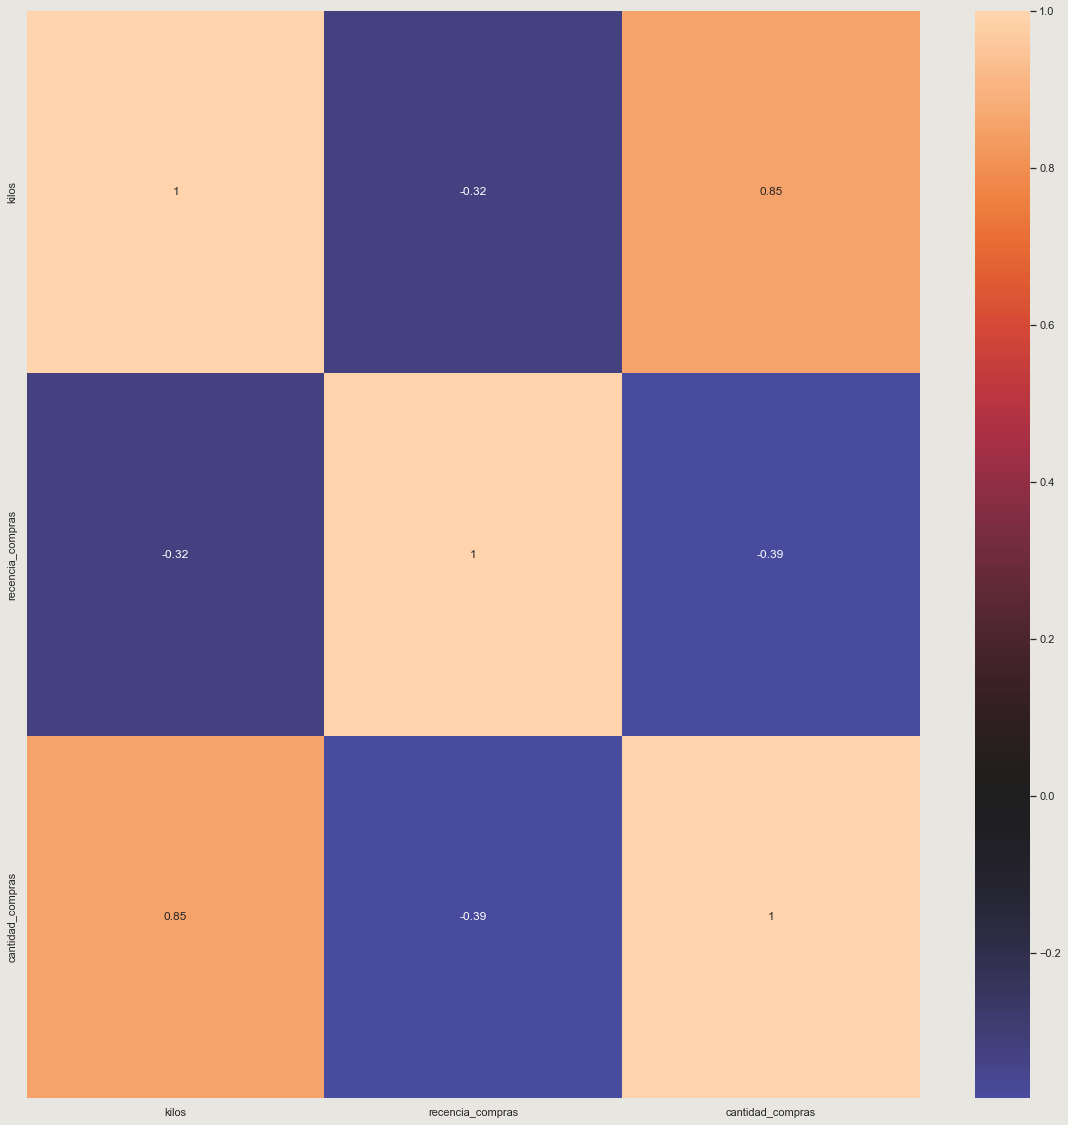

In [33]:
#correlation matrix
corrmat= X.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)

Analizo la existencia de outliers con gráficos pareados

<Figure size 432x288 with 0 Axes>

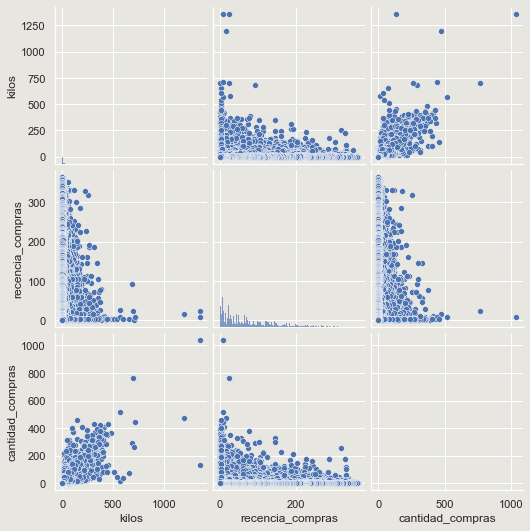

In [34]:
#To plot some selected features 
#Setting up colors prefrences
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
plt.figure()
sns.pairplot(X,palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

A partir de los gráficos, puedo reconocer los outliers.
- Cantidad de canjes tiene que ser menor a 300
- 


##### MEJORA: ELIMINAR OUTLIERS CON UN MÉTODO ESTANDARIZADO Y NO CON GRÁFICOS

In [36]:
def rango_intercuartilico(data):
    sort_data = np.sort(data)
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')  
    Q2 = np.percentile(data, 50, interpolation = 'midpoint')  
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    print('Devuelve Q1, Q2, Q3 y el límite superior')
    return (Q1,Q2,Q3, Q3 + 1.5 * IQR)

In [38]:
rango_intercuartilico(X['kilos'])

Devuelve Q1, Q2, Q3 y el límite superior


(1.59, 3.91, 8.872, 19.795)

In [40]:
X['kilos'].std()

7.339068254227329

In [42]:
X['kilos'].shape

(2684318,)

In [22]:
rango_intercuartilico(X['kilos'])

Devuelve Q1, Q2, Q3 y el límite superior


(1.99, 5.1, 12.225, 27.5775)

In [60]:
rango_intercuartilico(X['recencia_compras'])

Devuelve Q1, Q2, Q3 y el límite superior


(17.0, 66.0, 288.0, 694.5)

In [23]:
rango_intercuartilico(X['ticket_promedio'])

Devuelve Q1, Q2, Q3 y el límite superior


(0.6433333333333333, 0.965, 1.325, 2.3475)

In [79]:
rango_intercuartilico(X['cantidad_compras'])

Devuelve Q1, Q2, Q3 y el límite superior


(2.0, 5.0, 12.0, 27.0)

In [90]:
X[(X.kilos > 27.6) | (X.ticket_promedio >2.34) | (X.cantidad_compras > 27)].shape[0] / X.shape[0] * 100

13.076477449506122

Por el momento lo dejo como está porque quiero que a los outliers también me los agrupe. Los límites superiores están bastante bajos.

In [65]:
X.describe()

,kilos,cantidad_canjes,recencia_compras
count,3.082252e+06,3.082252e+06,3.082252e+06
mean,9.472033e+00,6.152028e-01,1.759972e+02
std,1.468869e+01,2.174815e+00,2.131081e+02
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.720000e+00,0.000000e+00,1.700000e+01
50%,4.700000e+00,0.000000e+00,6.600000e+01
75%,1.144000e+01,1.000000e+00,2.880000e+02
max,2.994770e+02,2.150000e+02,7.000000e+02


Elimino nulos

In [43]:
X.isnull().sum()

CustomerId          0
kilos               0
recencia_compras    0
cantidad_compras    0
dtype: int64

In [67]:
X.kilos.fillna(0,inplace=True)

C:\Users\Pablo\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [68]:
X.dropna(how='any',inplace=True)

<ipython-input-68-5445dbc9db56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(how='any',inplace=True)


In [38]:
X[X.kilos > 100 ].shape[0] / X.shape[0]*100

0.4769785283436503

### Isolation Forest para detectar outliers

In [54]:
df_i_f = X[['kilos','cantidad_compras','recencia_compras']]
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination= 'auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df_i_f)

IsolationForest(n_jobs=-1, random_state=42)

In [55]:
pred = clf.predict(df_i_f)
df_i_f['anomaly'] = pred
outliers = df_i_f.loc[df_i_f['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_i_f['anomaly'].value_counts())

 1    2284727
-1     399591
Name: anomaly, dtype: int64


C:\Users\pnovero\AppData\Local\Temp\3/ipykernel_24560/733036111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i_f['anomaly'] = pred


In [56]:
df_i_f.head()

,kilos,cantidad_compras,recencia_compras,anomaly
0,0.820,2,43,1
1,22.017,3,56,-1
2,4.000,5,75,1
3,22.436,20,16,1
4,1.470,2,106,1


In [57]:
print('Segun Isolation forest, el ', 399591/(2284727+399591)*100,'% de los datos son outliers')

Segun Isolation forest, el  14.886127500542038 % de los datos son outliers


(20.0, 30.0)

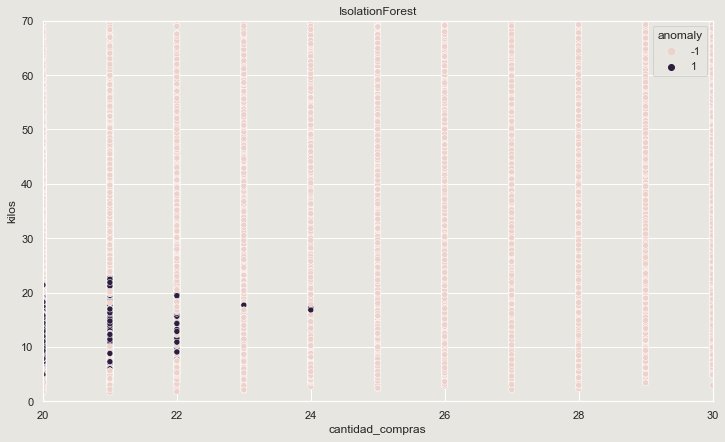

In [64]:
# Gráfico 2D

figsize=(12, 7)
plt.figure(figsize=figsize)
plt.title("IsolationForest")
sns.scatterplot(data=df_i_f,x='cantidad_compras',y='kilos',hue='anomaly')
plt.ylim((0,70))
plt.xlim((20,30))

In [63]:
df_i_f[df_i_f.anomaly ==-1].cantidad_compras.max()

1038

In [ ]:
print('según el algoritmo, los socios con más de estos kilos, son outliers:', df_i_f[df_i_f.anomaly == 1].kilos.max())
#print('según el algoritmo, los socios con más de este ticket promedio, son outliers:', df_i_f[df_i_f.anomaly == 1].ticket_promedio.max())
print('según el algoritmo, los socios con más de esta cantidad de compras, son outliers:', df_i_f[df_i_f.anomaly == 1].cantidad_compras.max())

In [ ]:
X[(X.kilos > 65) | (X.ticket_promedio >2.54) | (X.cantidad_compras > 75)].shape[0] / X.shape[0] * 100

#### Elimino Outliers

In [44]:
#X= X[X['cantidad_canjes']<300]

In [16]:
X = X[X.kilos <= 65]

In [17]:
X = X[X.ticket_promedio <= 2.5]

In [18]:
X = X[X.cantidad_compras <= 75]

##### Normalizar variables

Esto se hace para que las distancias sean las mismas en todos los ejes

In [45]:
scaler = StandardScaler()
scaler.fit(X.drop(columns=['CustomerId']))
X_standard = pd.DataFrame(scaler.transform(X.drop(columns=['CustomerId'])),columns= X.drop(columns=['CustomerId']).columns)
X_standard.head()

,kilos,recencia_compras,cantidad_compras
0,-0.563116,-0.559373,-0.546615
1,1.267877,-0.393659,-0.440533
2,-0.288428,-0.151461,-0.228370
3,1.304070,-0.903548,1.362854
4,-0.506969,0.243703,-0.546615


##### Método del codo para definir cantidad de clusters

In [46]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_standard)
    kmeanModel.fit(X_standard)

    distortions.append(sum(np.min(cdist(X_standard, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X_standard.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_standard, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / X_standard.shape[0]
    mapping2[k] = kmeanModel.inertia_


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertia')
plt.show()

Pruebo con k=4

#### Implemento el algoritmo

In [47]:
kmeans = KMeans(n_clusters=3,random_state=2).fit(X_standard)
labels = kmeans.predict(X_standard)
# Obtengo los 4 centroides
C = kmeans.cluster_centers_

In [48]:
X['labels_kmeans'] = labels
#principalDf['labels_kmeans'] = labels

C:\Users\pnovero\AppData\Local\Temp\3/ipykernel_24560/3303671808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['labels_kmeans'] = labels


##### Evalúo el algoritmo

In [49]:
metrics.silhouette_score(X_standard, labels,sample_size=15000)

0.4547943749927474

In [50]:
X['labels_kmeans'] = np.where(X['labels_kmeans']==0,'Clientes Plata',np.where(X['labels_kmeans']==1,'Clientes Bronce',np.where(X['labels_kmeans']==2,'Clientes Oro','Exclusivo Canjes')))
consumo_clientes = consumo_clientes.merge(X[['CustomerId','labels_kmeans']],on='CustomerId',how='left')
consumo_clientes.head()

C:\Users\pnovero\AppData\Local\Temp\3/ipykernel_24560/1696289254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['labels_kmeans'] = np.where(X['labels_kmeans']==0,'Clientes Plata',np.where(X['labels_kmeans']==1,'Clientes Bronce',np.where(X['labels_kmeans']==2,'Clientes Oro','Exclusivo Canjes')))


,CustomerId,GenderCode,edad,recencia_compras,cantidad_compras,kilos,lineas_probadas,cantidad_canjes,kilos_canjeados,recencia_canjes,años_activo,frecuencia_compra,%_promociones,ticket_promedio,labels_kmeans
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,Female,37,43,2,0.820,3,0,0.0,800,8.449181,365,0.0,0.4100,Clientes Bronce
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,Male,47,56,3,22.017,8,0,0.0,800,8.460133,243,33.3,7.3390,Clientes Bronce
2,D29ED1F9-7C81-C0F3-23AA-08D0BF502D86,Male,29,75,5,4.000,3,0,0.0,800,8.460133,146,0.0,0.8000,Clientes Bronce
3,24FB0387-327A-CD4B-5792-08D0C3298D3B,Female,48,16,20,22.436,8,2,1.0,22,8.443705,36,0.0,1.1218,Clientes Oro
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,Female,38,106,2,1.470,3,0,0.0,800,8.460133,365,0.0,0.7350,Clientes Bronce


C:\Users\pnovero\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


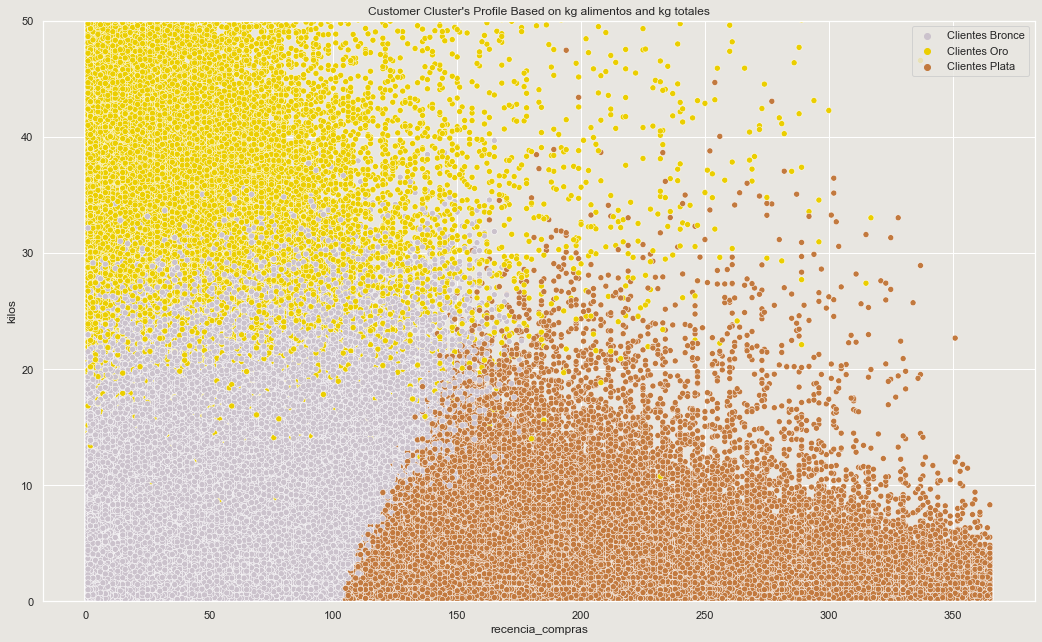

In [53]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure(figsize=(1280*px,769*px))
pl = sns.scatterplot(data = X, x='recencia_compras', y='kilos',hue='labels_kmeans',palette = ['#CBC2CC','#EBCE00','#C2793E'])
pl.set_title("Customer Cluster's Profile Based on kg alimentos and kg totales")
plt.ylim((0,50))
plt.legend()

plt.show()

In [ ]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure(figsize=(1280*px,769*px))
pl = sns.scatterplot(data = X, x='recencia_compras', y='kilos',hue='labels_kmeans',palette = ['#CBC2CC','#EBCE00','#C2793E','#185196'])
pl.set_title("Customer Cluster's Profile Based on kg alimentos and kg totales")
plt.legend()

plt.show()

In [26]:
X.stb.freq(['labels_kmeans'],cum_cols=False)

,labels_kmeans,count,percent
0,Clientes Plata,1804345,61.178734
1,Clientes Oro,745936,25.291959
2,Clientes Bronce,398318,13.505505
3,Exclusivo Canjes,702,0.023802


In [27]:
X.groupby('labels_kmeans').kilos.sum()/ X.kilos.sum() * 100

labels_kmeans
Clientes Bronce     46.287237
Clientes Oro         6.892972
Clientes Plata      46.797534
Exclusivo Canjes     0.022256
Name: kilos, dtype: float64

Text(0.5, 0, 'Cantidad de socios')

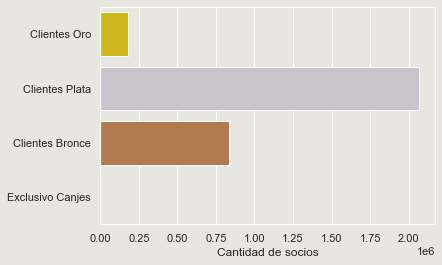

In [38]:
sns.countplot(y=X['labels_kmeans'],palette = ['#EBCE00','#CBC2CC','#C2793E','#185196'],order=['Clientes Oro','Clientes Plata','Clientes Bronce','Exclusivo Canjes'])
plt.ylabel('')
plt.xlabel('Cantidad de socios')

#### Gráfico de caja comparativo con cantidad de productos canjeados

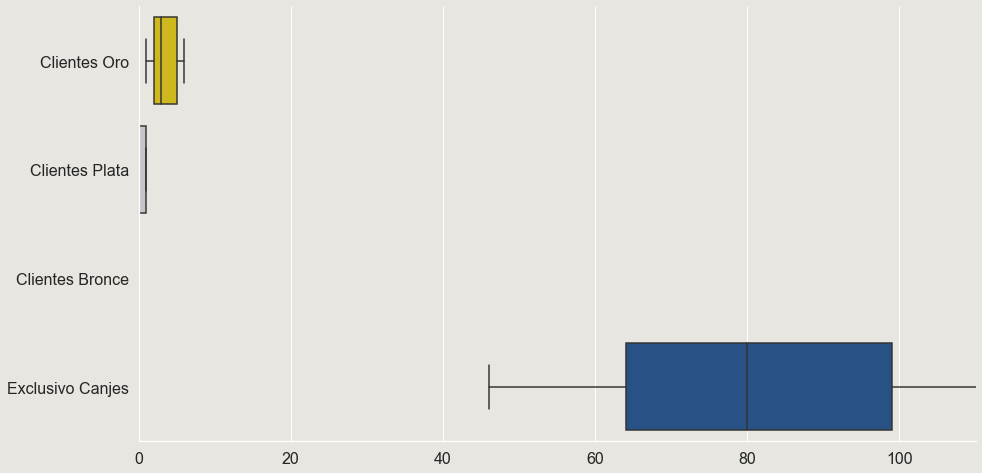

In [39]:
fig, axes = plt.subplots(figsize=(15,8))

sns.boxplot(x="cantidad_canjes", y="labels_kmeans", ax=axes, data=X, orient="h", showfliers=False, whis=0.666,\
            palette = ['#EBCE00','#CBC2CC','#C2793E','#185196'],\
            order=['Clientes Oro','Clientes Plata','Clientes Bronce','Exclusivo Canjes'])

for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)


plt.xlim(0,110)
#plt.title('Kilos por segmento')
plt.ylabel(None)
plt.xlabel(None)
sns.despine()


In [91]:
print('2,6 std:',X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.mean() + 2.6* X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.std())
print('media:',X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.mean())
print('- 2,6 std:',X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.mean() - 2.6* X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.std())
print('minimos canje ORO',X[X.labels_kmeans =='Clientes Oro'].cantidad_canjes.min() )

2,6 std: 15.546748564097314
media: 4.592425501602754
- 2,6 std: -6.361897560891805
minimos canje ORO 0


#### Gráfico de caja comparativo con cantidad de kilos

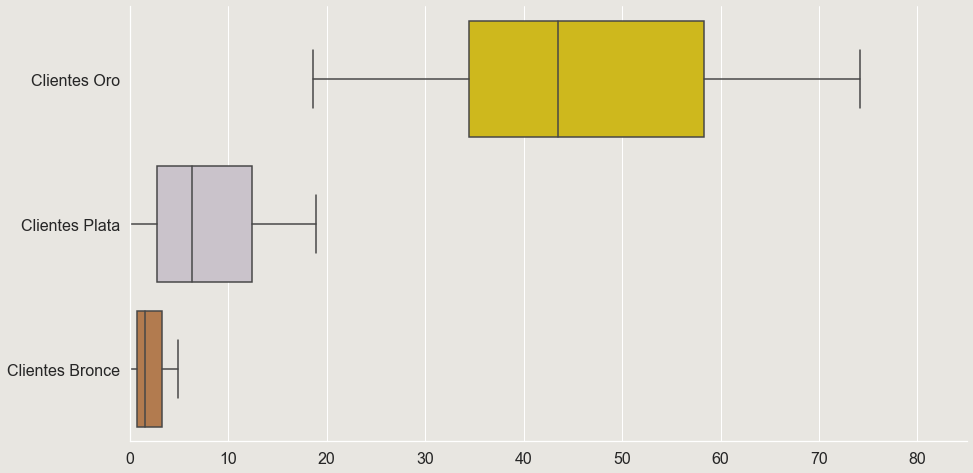

In [100]:
fig, axes = plt.subplots(figsize=(15,8))

sns.boxplot(x="kilos", y="labels_kmeans", ax=axes, data=X, orient="h", showfliers=False, whis=0.666,\
            palette = ['#EBCE00','#CBC2CC','#C2793E'], order=['Clientes Oro','Clientes Plata','Clientes Bronce'])

for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.xlim(0,85)
#plt.title('Kilos por segmento')
plt.ylabel(None)
plt.xlabel(None)
sns.despine()


In [94]:
print('2,6 std:',X[X.labels_kmeans =='Clientes Oro'].kilos.mean() + 2.6* X[X.labels_kmeans =='Clientes Oro'].kilos.std())
print('media:',X[X.labels_kmeans =='Clientes Oro'].kilos.mean())
print('- 2,6 std:',X[X.labels_kmeans =='Clientes Oro'].kilos.mean() - 2.6* X[X.labels_kmeans =='Clientes Oro'].kilos.std())
print('minimo kilaje ORO',X[X.labels_kmeans =='Clientes Oro'].kilos.min())


2,6 std: 152.95613742679538
media: 52.500057586089014
media: 0    34.0
dtype: float64
- 2,6 std: -47.95602225461735
minimo kilaje ORO 0.0


#### Gráfico de caja comparativo con recencia de compras

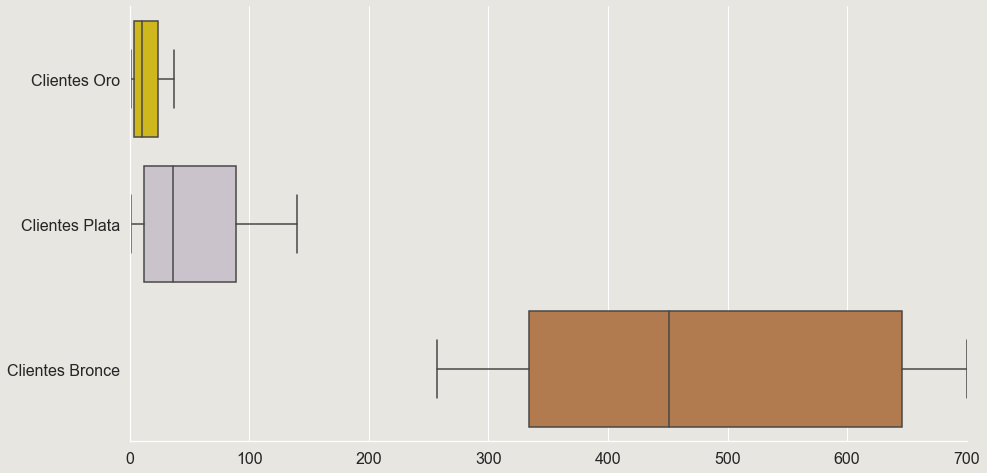

In [101]:
fig, axes = plt.subplots(figsize=(15,8))

sns.boxplot(x="recencia_compras", y="labels_kmeans", ax=axes, data=X, orient="h", showfliers=False, whis=0.666,\
            palette = ['#EBCE00','#CBC2CC','#C2793E'], order=['Clientes Oro','Clientes Plata','Clientes Bronce'])

for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.xlim(0,700)
#plt.title('Kilos por segmento')
plt.ylabel(None)
plt.xlabel(None)
sns.despine()


In [99]:
print('2,6 std:',X[X.labels_kmeans =='Clientes Oro'].recencia_compras.mean() + 2.6* X[X.labels_kmeans =='Clientes Oro'].recencia_compras.std())
print('media:',X[X.labels_kmeans =='Clientes Oro'].recencia_compras.mean())
print('mediana:',X[X.labels_kmeans =='Clientes Oro'].recencia_compras.median())
print('- 2,6 std:',X[X.labels_kmeans =='Clientes Oro'].recencia_compras.mean() - 2.6* X[X.labels_kmeans =='Clientes Oro'].recencia_compras.std())
print('minimo kilaje ORO',X[X.labels_kmeans =='Clientes Oro'].recencia_compras.min())

print('mediana Plata:',X[X.labels_kmeans =='Clientes Plata'].recencia_compras.median())


2,6 std: 167.17010621690488
media: 26.72841935064421
mediana: 10.0
- 2,6 std: -113.71326751561648
minimo kilaje ORO 1
mediana Plata: 36.0


In [104]:
consumo_clientes.columns

Index(['CustomerId', 'GenderCode', 'categoria', 'recencia_compras',
       'cantidad_compras', 'kilos', 'lineas_probadas', 'cantidad_canjes',
       'puntos_canjeados', 'recencia_canjes', 'edad', 'años de activo',
       'Frecuencia de compra', '% promociones', 'labels_kmeans'],
      dtype='object')

#### Gráfico de caja comparativo con frecuencia de compras

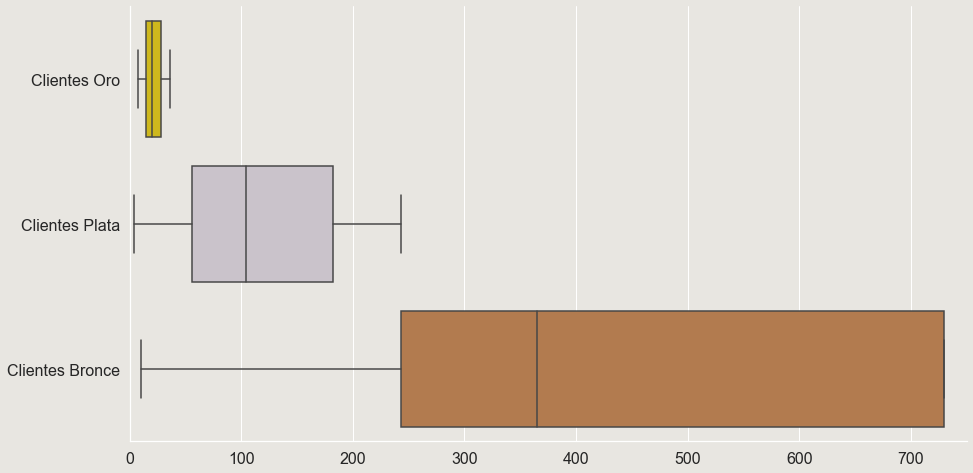

In [102]:
fig, axes = plt.subplots(figsize=(15,8))

sns.boxplot(x="Frecuencia de compra", y="labels_kmeans", ax=axes, data=consumo_clientes, orient="h", showfliers=False, whis=0.666,\
            palette = ['#EBCE00','#CBC2CC','#C2793E'], order=['Clientes Oro','Clientes Plata','Clientes Bronce'])

for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.xlim(0,750)
#plt.title('Kilos por segmento')
plt.ylabel(None)
plt.xlabel(None)
sns.despine()


In [100]:
X.groupby('labels_kmeans').agg({'kilos':['mean','median'],'recencia_compras':['mean','median'],'cantidad_canjes':['mean','median']})

kilos         recencia_compras        cantidad_canjes  \
                       mean  median             mean median            mean   
labels_kmeans                                                                 
Clientes Bronce    2.579972   1.600       483.378303    451        0.087996   
Clientes Oro      52.500058  43.514        26.728419     10        4.592426   
Clientes Plata     8.692671   6.300        64.469309     36        0.459187   
Exclusivo Canjes  39.930559   6.165       114.916959     45       86.659649   

                         
                 median  
labels_kmeans            
Clientes Bronce       0  
Clientes Oro          3  
Clientes Plata        0  
Exclusivo Canjes     80

##### Interpreto el algoritmo

<Figure size 1280x769 with 0 Axes>

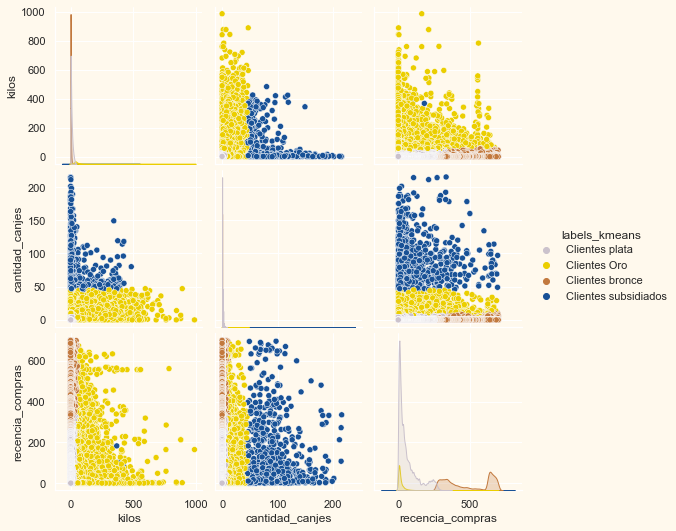

In [44]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})

#Plotting following features

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure(figsize=(1280*px,769*px))

sns.pairplot(X,hue='labels_kmeans',palette =  ['#CBC2CC','#EBCE00','#C2793E','#185196'])

#Taking hue 
plt.show()

##### Interpretación:

* Clientes Oro: Clientes oro. Revisar los que tienen recencia alta, formaría otro grupo. 
* Clientes Plata: Grupo mayoritario. Presentan bajo kilaje pero compraron dentro de los ultimos 10 meses
* Clientes Bronce: 
* Clientes canjeadores: Canjean mucho gracias a puntos regalados.

El grupo 0 se convertirá en 1 o 2 dependiendo de su comportamiento inmediato.

In [91]:
consumo_clientes.groupby('labels_kmeans').agg({'edad':['mean','median'],'lineas_probadas':['mean','median'],'años de activo':['mean','median'],'puntos_canjeados':['mean','median'],'Frecuencia de compra':['mean','median'],'ticket_promedio':['mean','median']})

edad        lineas_probadas        años de activo  \
                       mean median            mean median           mean   
labels_kmeans                                                              
Clientes Bronce   41.209344     39        2.240409      2       4.157813   
Clientes Oro      44.809473     44        8.309086      8       4.948129   
Clientes Plata    41.307831     40        4.325277      4       4.259238   
Exclusivo Canjes  32.670175     31        6.752047      5       5.369602   

                           puntos_canjeados          Frecuencia de compra  \
                    median             mean   median                 mean   
labels_kmeans                                                               
Clientes Bronce   4.186260     4.375938e+02        0           446.861272   
Clientes Oro      5.251306     3.209490e+04    22000            24.041869   
Clientes Plata    4.517547     2.612775e+03        0           173.845914   
Exclusivo Canjes  5.963161     1.181962e+06  1065000           166.355556   

                        ticket_promedio            
                 median            mean    median  
labels_kmeans                                      
Clientes Bronce     365        0.975888  0.845333  
Clientes Oro         20        1.344549  1.219407  
Clientes Plata      104        0.947428  0.874500  
Exclusivo Canjes     91        0.883810  0.810000

##### Cantidad de compras vs kilos

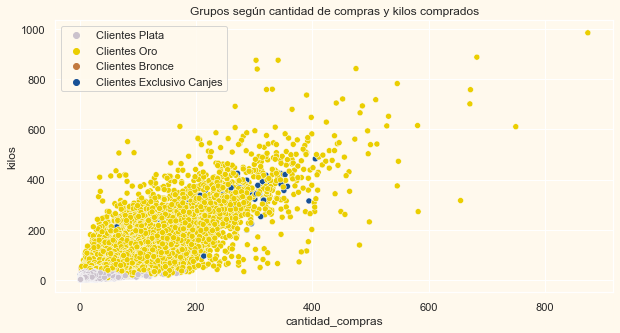

In [61]:
plt.figure(figsize=(10,5))
pl = sns.scatterplot(data = consumo_clientes, x='cantidad_compras', y='kilos',hue ='labels_kmeans',palette = ['#CBC2CC','#EBCE00','#C2793E','#185196'])
pl.set_title("Grupos según cantidad de compras y kilos comprados")
plt.legend()
plt.show()

##### Cantidad de canjes vs kilos

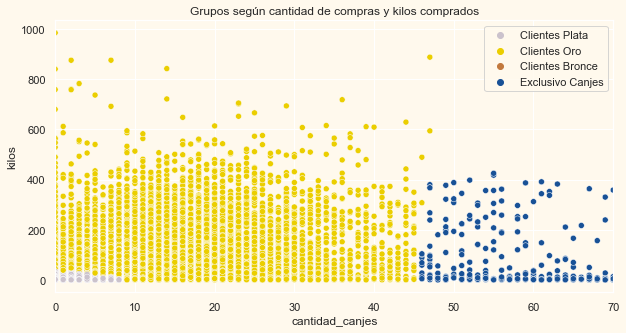

In [144]:
plt.figure(figsize=(10,5))
pl = sns.scatterplot(data = consumo_clientes, x='cantidad_canjes', y='kilos',hue ='labels_kmeans',palette = ['#CBC2CC','#EBCE00','#C2793E','#185196'])
pl.set_title("Grupos según cantidad de compras y kilos comprados")
plt.legend()
plt.xlim(0,70)
plt.show()

In [145]:
consumo_clientes[consumo_clientes.labels_kmeans =='Exclusivo Canjes'].cantidad_canjes.min()

46

##### Años de activo vs kilos

C:\Users\Pablo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


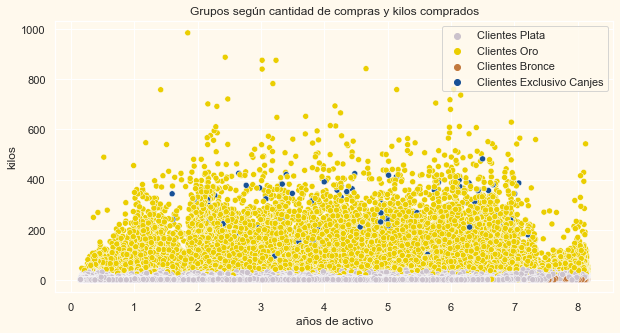

In [66]:
plt.figure(figsize=(10,5))
pl = sns.scatterplot(data = consumo_clientes, x='años de activo', y='kilos',hue ='labels_kmeans',palette = ['#CBC2CC','#EBCE00','#C2793E','#185196'])
pl.set_title("Grupos según cantidad de compras y kilos comprados")
plt.legend()
plt.show()

Límites:
 - Más de 48 canjes, va para socios exclusivos canjes
 - Más de xx Kilos: Cliente Oro
 - + de 300 días de recencia y menos de xx Kilos: Bronce
 - menos de 300 días de recencia y menos de xx Kilos: Plata

In [64]:
consumo_clientes.groupby(['labels_kmeans','GenderCode']).agg({'CustomerId':'nunique'}).groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

CustomerId
labels_kmeans             GenderCode            
Clientes Bronce           Female       60.565265
                          Male         39.434735
Clientes Exclusivo Canjes Female       21.286550
                          Male         78.713450
Clientes Oro              Female       57.984091
                          Male         42.015909
Clientes Plata            Female       61.631581
                          Male         38.368419

In [68]:
consumo_clientes.groupby(['labels_kmeans','GenderCode']).agg({'edad':['mean','median'],'años de activo':['mean','median']})

edad        años de activo  \
                                           mean median           mean   
labels_kmeans             GenderCode                                    
Clientes Bronce           Female      41.607831     40       4.193398   
                          Male        40.553857     38       4.061503   
Clientes Exclusivo Canjes Female      33.153846     32       5.011212   
                          Male        32.502229     31       5.445652   
Clientes Oro              Female      44.640927     44       4.985876   
                          Male        45.001251     44       4.856938   
Clientes Plata            Female      41.417042     40       4.288895   
                          Male        41.087838     40       4.168785   

                                                
                                        median  
labels_kmeans             GenderCode            
Clientes Bronce           Female      4.230066  
                          Male        4.076744  
Clientes Exclusivo Canjes Female      5.448435  
                          Male        6.168504  
Clientes Oro              Female      5.295112  
                          Male        5.166431  
Clientes Plata            Female      4.602422  
                          Male        4.377913

## Recomendación utilizando librería LightFM

En desarrollo........

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()

### A Priori Algorithm

Armo la columna línea con lo que me interesa y tomo solo a las ventas que no hayan sido por promociones ¿Por qué? quiero encontrar relaciones entre productos genuinas, no fomentadas por una promo

In [120]:
ventas.head()

,SaleId,SaleDetailId,CustomerId,SaleDate,BranchOfficeId,Amount,ProductId,ProductName,PromotionId,PromotionName,Points,codigo,linea_producto,idCategoria
0,113454287,187361023,4815070D-C6D7-CCA4-3A3B-08D57BB26A7A,2021-10-23 18:42:02.1997405 +00:00,805B1145-22BE-C0EF-7D76-08D98299185E,1,66.0,1/4 Kilo,4931.0,2 1/4 Kg x $300,0,66.0,Helado X Kilo,2.0
1,113454300,187361042,3F2EE0A0-F50E-CA82-F32A-08D6A18F6D8A,2021-10-23 18:42:09.7777392 +00:00,F959066B-EE78-C00E-8172-08D286442DAA,1,65.0,1/2 Kilo,NaN,NaN,350,65.0,Helado X Kilo,2.0
2,113454290,187361029,756FDFB7-D24E-CC70-1E8B-08D333DD3074,2021-10-23 18:42:04.6742063 +00:00,569E5C3A-9731-C2A8-9858-08D22EEBA6D4,1,65.0,1/2 Kilo,NaN,NaN,300,65.0,Helado X Kilo,2.0
3,113454360,187361136,4729D01A-9757-CC09-A621-08D36151A6B0,2021-10-23 18:42:45.5765089 +00:00,4EA8D3F8-F5F2-C568-4A8A-08D2863CA84B,1,17.0,Tentacion 1 Lt Dulce De Leche,NaN,NaN,300,17.0,Pote 1 Litro,2.0
4,113454322,187361084,95CEABD1-B524-CB39-0ADB-08D93E7D366F,2021-10-23 18:42:21.4664581 +00:00,213E38E5-4E6E-CA8E-5625-08D275943D04,1,52.0,Palito Frutal Frutilla En Caja X 20,NaN,NaN,350,52.0,Palitos,2.0


In [121]:
ventas = ventas[ventas.PromotionId.isnull()]

In [153]:
ventas = ventas[pd.to_datetime(ventas.SaleDate).dt.date >= dt.datetime(2021,6,1).date()]

(16066461, 15)

Creo unas nuevas lineas de producto de acuerdo a la forma en la que se consumen los productos. Aclaro que esto es totalmente subjetivo de acuerdo a lo que me parece acertado y accionable

In [128]:
ventas['Linea'] = ventas['linea_producto']

ventas['Linea'] = np.where(ventas['idCategoria']==3,'Congelado',ventas['Linea'])

#ventas['Linea'] = np.where((ventas['Linea']== 'Tortas')|(ventas['Linea']== 'Semifrío')|\
#    (ventas['ProductName'] == 'BARRA DELICIA CHOCOLATE Y MANI')|(ventas['ProductName']== 'Crocantino'),\
#    'Postres nuevo',ventas['Linea'])


ventas['Linea'] = np.where(((~ventas['ProductName'].str.contains('X 8',case=False)) & (~ventas['ProductName'].str\
    .contains('X 10',case=False))&(~ventas['ProductName'].str.contains('X 20'))&(~ventas['ProductName'].str.contains('x20')))\
    & ((ventas['Linea'] == 'Palitos')|(ventas['Linea'] == 'Bombones')|(ventas['Linea'] == 'Postres'))\
    ,'Por unidad',ventas['Linea'])


ventas['Linea'] = np.where(ventas['Linea']=='Factura','Café',ventas['Linea'])

ventas['Linea'] = np.where(ventas['Linea']=='Especial','Líneas Especiales',ventas['Linea'])

#ventas['Linea'] = np.where(ventas['Linea']=='Helado x Bocha','Por unidad',ventas['Linea'])

ventas['Linea'] = np.where(ventas['ProductName'].str.contains('1 Kilo',case=False),'1 kg',ventas['Linea'])

ventas['Linea'] = np.where((ventas['Linea']=='Cups y vasos')|(ventas['Linea']=='Tops'),'A definir',ventas['Linea'])

# Se podria agregar helado por bocha + por unidades

In [60]:
ventas = ventas[ventas.PromotionId.isnull()].copy()
ventas.drop(columns=['ProductId','BranchOfficeId','PromotionId','PromotionName','Kilos'],inplace=True)

In [129]:
ventas.Linea.value_counts(normalize=True)*100

Helado x Bocha       16.429110
Helado X Kilo        15.655855
1 kg                 13.122156
No Definido           7.397639
Bombones              7.338731
Por unidad            7.205733
Líneas Especiales     7.123154
Pote 1 Litro          6.096782
Palitos               5.744971
Familiar              5.180234
Tortas                4.121751
Congelado             2.126048
Postres               1.794025
Semifrío              0.617389
Café                  0.046422
Name: Linea, dtype: float64

In [156]:
lineas_elegidas = ['Helado X Kilo', 'Pote 1 Litro', 'Palitos','Bombones', 'Familiar', 'Por unidad', 'Líneas Especiales',
       'Helado x Bocha', '1 kg', 'Postres', 'Semifrío', 'Congelado','Tortas', 'Café']
basket= ventas[ventas.Linea.isin(lineas_elegidas)].groupby(['SaleId', 'Linea'])['Amount'].sum().unstack().reset_index().fillna(0).set_index('SaleId')
basket.head()

Linea,1 kg,Bombones,Café,Congelado,Familiar,Helado X Kilo,Helado x Bocha,Líneas Especiales,Palitos,Por unidad,Postres,Pote 1 Litro,Semifrío,Tortas
SaleId,,,,,,,,,,,,,,
107010178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
107010179,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107010180,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107010181,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107010182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0


In [157]:
# Defining the hot encoding function to make the data suitable
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

In [158]:
basket = basket.applymap(hot_encode)
basket= basket.astype('int32')

In [ ]:
# Building the model
frq_items = apriori(basket, min_support = 0.008, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules


- Support: numero de transacciones donde aparece x item sobre el total de transacciones
- Confidence: probabilidad condicional P(A|B) = (P(A y B)/P(A)): la prob de que se venda B dado que se vendió A
- Lift: probabilidad de que ambos items sean comprados juntos. 
        - Si lift < 1, hay mas probabilidad de que los items se compren por separado
        - Si lift =1, no hay asociacion entre los items
        - Si lift > 1, hay asociacion entre los items

In [139]:
frq_items

,support,itemsets
0,0.193366,(1 kg)
1,0.099323,(Bombones)
2,0.023758,(Congelado)
3,0.077989,(Familiar)
4,0.227169,(Helado X Kilo)
5,0.205235,(Helado x Bocha)
6,0.096860,(Líneas Especiales)
7,0.075959,(Palitos)
8,0.086422,(Por unidad)
9,0.025530,(Postres)


### Momentos de compra según segmento

In [40]:
ventas_tres_meses = ventas[pd.to_datetime(ventas.SaleDate).dt.date >= dt.datetime(2021,10,1).date()]
ventas_tres_meses.shape

(9732572, 16)

In [41]:
ventas_tres_meses = ventas_tres_meses.merge(consumo_clientes[['CustomerId','labels_kmeans']],how='left')
ventas_tres_meses.shape

(9732572, 17)

In [42]:
segmentos = [ 'Clientes Oro','Clientes Plata', 'Clientes Bronce']

In [53]:
ventas_tres_meses.columns

Index(['SaleId', 'SaleDetailId', 'CustomerId', 'SaleDate', 'BranchOfficeId',
       'Amount', 'ProductId', 'ProductName', 'PromotionId', 'PromotionName',
       'Points', 'codigo', 'linea_producto', 'idCategoria', 'peso', 'kilos',
       'labels_kmeans'],
      dtype='object')

In [57]:
print('20 productos más vendidos en el segmento Clientes Oro')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Oro'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Oro'].groupby('linea_producto').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(5)

20 productos más vendidos en el segmento Clientes Oro


,linea_producto,kilos
16,Helado X Kilo,33.7
10,Familiar,17.6
25,Palitos,12.7
30,Pote 1 Litro,10.4
3,Bombones,7.4


In [58]:
print('20 productos más vendidos en el segmento Clientes Plata')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Plata'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Plata'].groupby('linea_producto').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(5)

20 productos más vendidos en el segmento Clientes Plata


,linea_producto,kilos
16,Helado X Kilo,33.5
10,Familiar,14.4
24,Palitos,11.5
3,Bombones,9.7
29,Pote 1 Litro,7.6


In [59]:
print('20 productos más vendidos en el segmento Clientes Bronce')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Bronce'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Bronce'].groupby('linea_producto').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(5)

20 productos más vendidos en el segmento Clientes Bronce


,linea_producto,kilos
12,Helado X Kilo,23.7
9,Familiar,14.9
20,Palitos,14.3
3,Bombones,14.2
28,Tortas,9.2


### Productos más vendidos por segmentos

In [63]:
print('5 productos más vendidos en el segmento Clientes Oro')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Oro'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Oro'].groupby('ProductName').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(20)

5 productos más vendidos en el segmento Clientes Oro


,ProductName,kilos
0,1 Kilo,24.5
84,Familiar Nº 2 (Americana/Frutilla/Ddl Graniz.),5.3
3,1/2 Kilo,5.0
86,Familiar Nº 4 (D.Leche G/Vainilla/Chocolate),4.4
85,Familiar Nº 3 (vainilla/frutilla/granizado),4.0
83,Familiar Nº 1 (chocolate/d.leche/americana),3.9
190,Palito Bombon En Caja X 20,3.8
21,Bombon Escoces En Caja X 8,3.7
196,Palito Frutal Frutilla En Caja X 20,3.6
5,1/4 Kilo,3.1


In [61]:
print('5 productos más vendidos en el segmento Clientes Plata')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Plata'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Plata'].groupby('ProductName').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(5)

5 productos más vendidos en el segmento Clientes Plata


,ProductName,kilos
0,1 Kilo,21.0
3,1/2 Kilo,6.6
5,1/4 Kilo,5.3
23,Bombon Escoces En Caja X 8,4.8
86,Familiar Nº 2 (Americana/Frutilla/Ddl Graniz.),4.5


In [62]:
print('5 productos más vendidos en el segmento Clientes Bronce')
kilos_totales = ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Bronce'].kilos.sum()
ventas_tres_meses[ventas_tres_meses.labels_kmeans == 'Clientes Bronce'].groupby('ProductName').kilos.sum().apply(lambda x: round(x/kilos_totales*100,1)).reset_index().sort_values('kilos',ascending=False).head(5)

5 productos más vendidos en el segmento Clientes Bronce


,ProductName,kilos
0,1 Kilo,14.8
16,Bombon Escoces En Caja X 8,7.4
68,Familiar Nº 2 (Americana/Frutilla/Ddl Graniz.),4.5
136,Palito Bombon En Caja X 20,4.4
3,1/2 Kilo,4.4


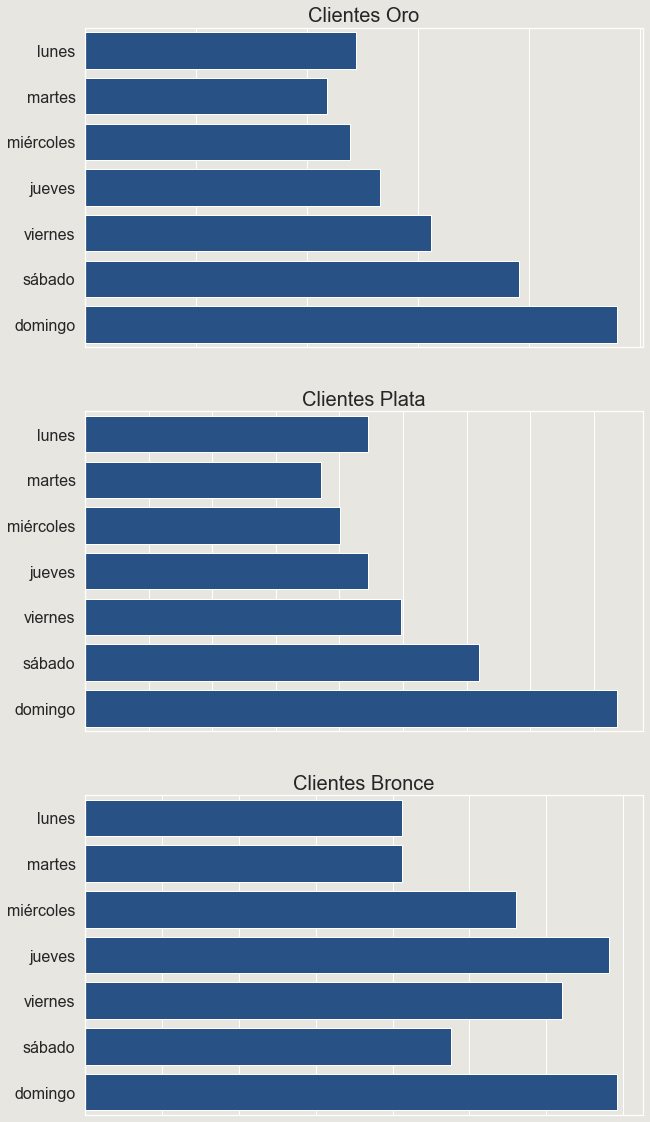

In [146]:
import locale
import calendar

fig, axes = plt.subplots(nrows=3,ncols= 1,figsize=(10,20))

for i,seg in enumerate(segmentos):
    locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
    dia = pd.to_datetime(ventas_tres_meses[ventas_tres_meses.labels_kmeans == seg]['SaleDate']).dt.weekday.apply(lambda x: calendar.day_name[x])
    axes[i].set_title(seg).set_fontsize(20)
    axes[i].tick_params(axis='y', labelsize=16)
    sns.countplot(y=dia, order = list(calendar.day_name), color='#185196',ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set(xticklabels=[])

In [147]:
for seg in segmentos:
    locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')
    dia = pd.to_datetime(ventas_tres_meses[ventas_tres_meses.labels_kmeans == seg]['SaleDate']).dt.weekday.apply(lambda x: calendar.day_name[x])
    print(dia.value_counts(normalize=True))

domingo      0.222828
sábado       0.182029
viernes      0.145055
jueves       0.123521
lunes        0.113765
miércoles    0.111287
martes       0.101516
Name: SaleDate, dtype: float64
domingo      0.231348
sábado       0.171425
viernes      0.137532
lunes        0.123332
jueves       0.122959
miércoles    0.110764
martes       0.102640
Name: SaleDate, dtype: float64
domingo      0.179370
jueves       0.176842
viernes      0.160961
miércoles    0.145485
sábado       0.123439
lunes        0.106951
martes       0.106951
Name: SaleDate, dtype: float64


##### Analizo las horas de mayor venta

In [156]:
horas = pd.to_datetime(ventas_tres_meses['SaleDate']).dt.hour
dia = pd.to_datetime(ventas_tres_meses['SaleDate']).dt.weekday.apply(lambda x: calendar.day_name[x])

dia_hora = pd.DataFrame(data={'dia':dia,'horas':horas,'labels_kmeans':ventas_tres_meses.labels_kmeans})
dia_hora.head()

,dia,horas,labels_kmeans
0,sábado,18,Clientes Plata
1,sábado,18,Clientes Oro
2,sábado,18,Clientes Plata
3,sábado,18,Clientes Plata
4,sábado,18,Clientes Plata


In [158]:
dia_hora.isnull().sum() / dia_hora.shape[0]

dia              0.000000
horas            0.000000
labels_kmeans    0.016105
dtype: float64

Text(0, 0.5, 'Horario de venta')

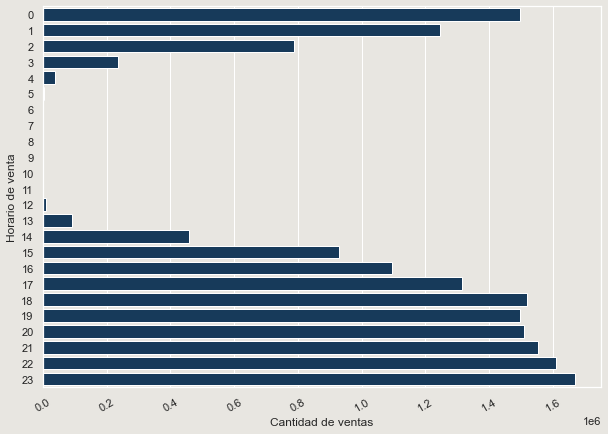

In [115]:
fig, ax = plt.subplots(figsize=(10,7))
ax.tick_params(axis='x', labelrotation = 30)
plt.title('')
fig = sns.countplot(y=horas, palette=["#0C3B65"])
ax.set_xlabel('Cantidad de ventas',loc='center')
ax.set_ylabel('Horario de venta',loc='center')

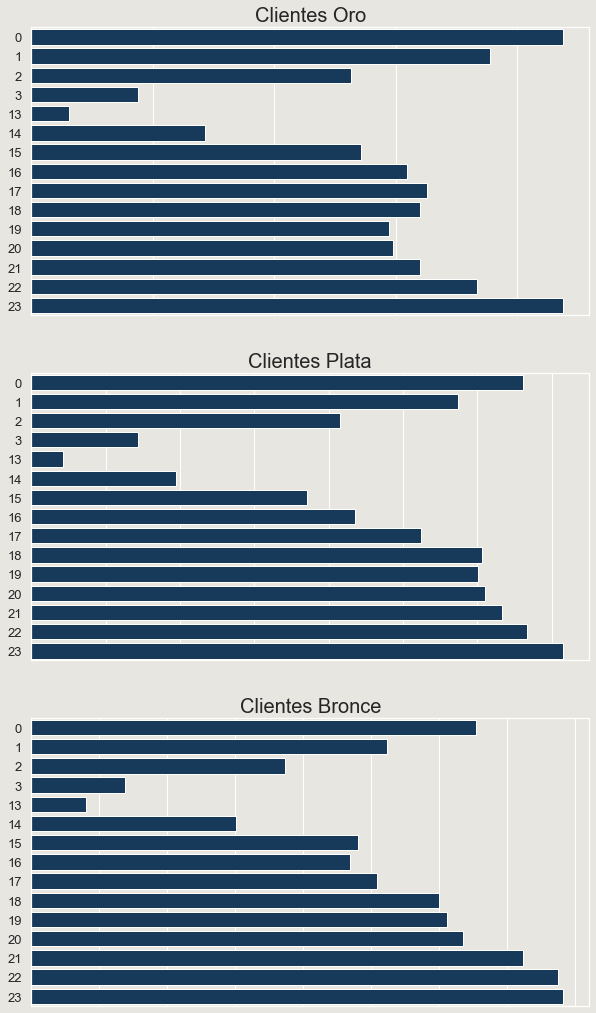

In [177]:
fig, axes = plt.subplots(nrows=3,ncols= 1,figsize=(10,18))

for i,seg in enumerate(segmentos):
    axes[i].set_title(seg).set_fontsize(20)
    axes[i].tick_params(axis='y', labelsize=13)
    axes[i].set(xticklabels=[])
    sns.countplot(y=dia_hora[(dia_hora.labels_kmeans == seg) & ~((4 <= dia_hora.horas) & (dia_hora.horas <= 12 ))].horas, palette=["#0C3B65"],ax=axes[i])
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set(xticklabels=[])

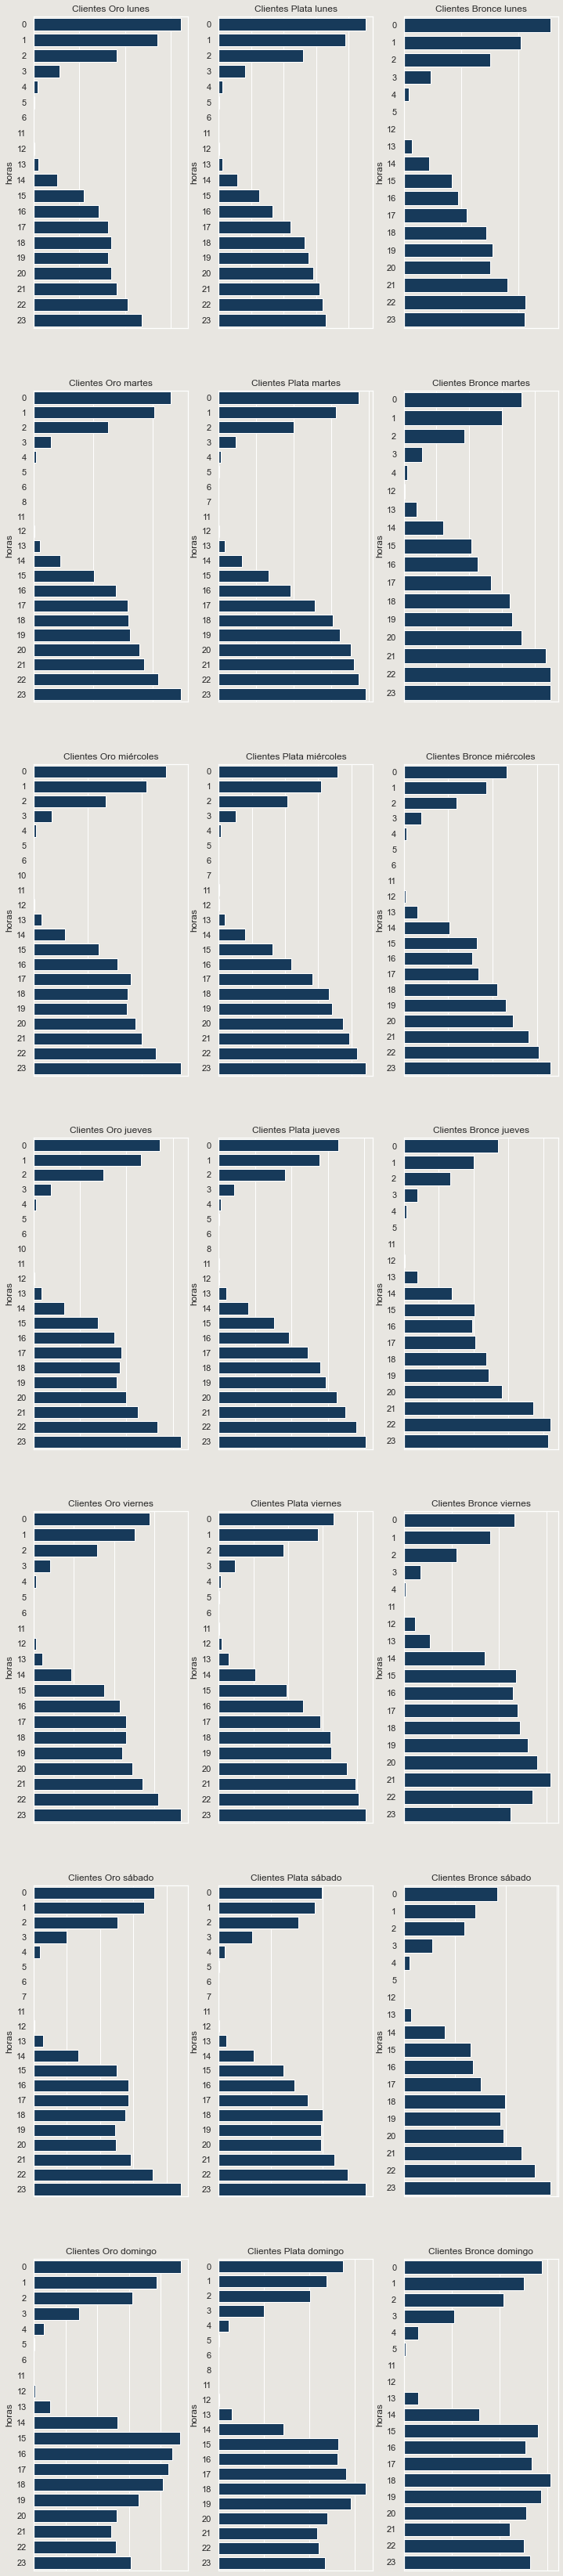

In [163]:
fig, axes = plt.subplots(nrows=7,ncols= 3,figsize=(12,60))

for col,seg in enumerate(segmentos):
    for fila,n_dia in enumerate(calendar.day_name[:]):
        axes[fila,col].tick_params(axis='x', labelrotation = 30)
        axes[fila,col].title.set_text(seg + ' ' + n_dia)
        axes[fila,col].set(xticklabels=[])
        sns.countplot(y=dia_hora[(dia_hora.dia == n_dia) & (dia_hora.labels_kmeans == seg)].horas, palette=["#0C3B65"],ax=axes[fila,col])
        axes[fila,col].set_xlabel('')